<span style="font-weight:bold; font-size:20px;">Import</span>

In [362]:
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy
from datetime import datetime
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
import shap
import matplotlib.gridspec as gridspec


<span style="font-weight:bold; font-size:20px;">All function</span>

In [3]:
# Data preprocessing
def data_pre(companies):
    for i in companies:
        if 'metadata' in i.keys():
            del i['metadata']
        comp_name = i['name']
        i['name'] = f"{comp_name}_{companies.index(i)}"
        if not isinstance(i['equity_funding_total_usd'], int):
            value = i['equity_funding_total_usd']
            i['equity_funding_total_usd'] = int(value['$numberLong'])
        if i['num_funding_rounds'] is None:
            i['num_funding_rounds'] = 0
    return companies

In [94]:
# The criteria to judge whether the company is successful
def whether_success(companies):
    for i in companies:
        i['startup'] = 'failed'
        if i['operating_status'] != 'closed':
            if i['went_public_on']:
                i['startup'] = 'success'
            elif i['status'] == 'was_acquired' or i['status'] == 'ipo':
                i['startup'] = 'success'
            elif i['num_acquisitions']:
                i['startup'] = 'success'
            # elif (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365 >= 7:
            #     i['startup'] = 'success'
            # elif i['num_funding_rounds'] >= 7:
            #     i['startup'] = 'success'
            elif i['equity_funding_total_usd'] >= 1000000000:
                i['startup'] = 'success'
            elif i['revenue_range'] is not None:
                i['startup'] = 'success'
    return companies

In [5]:
# Network building
def build_nw(comps, peo):
    G = nx.Graph()
    G.add_nodes_from(comps)
    
    peo_dict = {comp: set(p) for comp, p in zip(comps, peo)}
    
    def process_pairs(i, comp):
        edges = []
        for j in range(i+1, len(comps)):
            same = peo_dict[comp] & peo_dict[comps[j]]
            if same:
                edges.append((comp, comps[j], len(same)))
        return edges

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pairs, i, comp) for i, comp in enumerate(comps)]
        for future in as_completed(futures):
            for comp1, comp2, weight in future.result():
                if G.has_edge(comp1, comp2):
                    G[comp1][comp2]['weight'] += weight
                else:
                    G.add_edge(comp1, comp2, weight=weight)

    return G

In [6]:
# Calculate success rate
def success_rate(data, dict, field):
    result = {}
    for i in dict:
        result[i] = 0
        for n in data:
            if isinstance(n[field], list):
                if i in n[field] and n['startup'] == 'success':
                    result[i] += 1
            else:
                if n[field] == i and n['startup'] == 'success':
                    result[i] += 1
    for k in result:
        result[k] = result[k]/dict[k]
    return result

In [49]:
# def calculate_success_rate(data, years_threshold):
#     subset = [i for i in data if data[i]['Found year'] <= years_threshold]
#     year_success = [data[i]['startup'] for i in subset]
#     year_data = {}
#     for i, n in zip(subset, year_success):
#         year_data[i] = n
#     return year_data
# comp_year_success = {}
# for i in data:
#     comp_year_success[i['name']] = {'Found year': (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365, 'startup': i['startup']}

# year_5_data = calculate_success_rate(comp_year_success, 6)
# year_5_failed = [i for i in year_5_data if year_5_data[i] == 'failed']
# year_5_rate = len(year_5_failed) / len(year_5_data)
# year_10_data = calculate_success_rate(comp_year_success, 11)
# # for i in year_10_data:
# #     if i in year_5_failed:
# #         year_10_data[i] = 'failed'
# year_10_failed = [i for i in year_10_data if year_10_data[i] == 'failed']
# year_10_rate = len(year_10_failed) / len(year_10_data)
# print(year_5_rate)
# print(year_10_rate)

0.5685592249192625
0.48829170569431435


In [7]:
# Calculate component data
def components_data(G):
    result = {}
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        sub_size = len(subgraph)
        sub_success = 0
        for node in subgraph:
            if G.nodes[node]['success'] == 'success':
                sub_success += 1
        sub_success_rate = sub_success/sub_size
        density = nx.density(subgraph)
        for node in subgraph:
            result[node] = {'component_size': sub_size, 'component_success_rate': sub_success_rate, 'component_score':sub_success_rate * density}
    return result

In [8]:
# Basic analysis of the whole network
def generate_data(G):
    net_nodes = len(G.nodes())
    net_edges = len(G.edges())
    net_den = round(nx.density(G),4)
    avg_cluster = round(nx.average_clustering(G),4)
    avg_degree = round(np.mean(list(dict(G.degree()).values())),4)
    max_degree = max(list(dict(G.degree()).values()))
    min_degree = min(list(dict(G.degree()).values()))
    # total_strength = 0
    # for node in G.nodes():
    #     node_strength = sum(data["weight"] for u, v, data in G.edges(node, data=True))
    #     total_strength += node_strength
    # avg_strength = round(total_strength / net_nodes, 4)
    try:
        net_assortativity = round(nx.degree_assortativity_coefficient(G),4)
    except RuntimeWarning:
        net_assortativity = None

    table ={
        "Number of Nodes": net_nodes,
        "Number of Edges": net_edges,
        "Density": net_den,
        "Avg Clustering Coefficient": avg_cluster,
        "Avg Degree": avg_degree,
        "Max Degree": max_degree,
        "Min Degree": min_degree,
        # "Avg Strength": avg_strength,
        "Assortativity": net_assortativity}    
    return table

In [9]:
# Generate the features
def generate_feature(G, data):
    degrees = dict(G.degree())
    # clustering = nx.clustering(G)
    closeness = nx.closeness_centrality(G)
    # betweenness = nx.betweenness_centrality(G)
    # eigenvector_centrality = nx.eigenvector_centrality(G)
    # pagerank = nx.pagerank(G)
    
    nodes = [i['name'] for i in data]
    fea_info = {
        'node_id': nodes,
        'degree': [degrees[node] for node in nodes],
        # 'clustering': [clustering[node] for node in nodes],
        'closeness': [closeness[node] for node in nodes],
        # 'betweenness': [betweenness[node] for node in nodes],
        # 'closeness': [closeness[node] for node in nodes],
        # 'eigenvector_centrality': [eigenvector_centrality[node] for node in nodes],
        # 'pagerank': [pagerank[node] for node in nodes],
        'categories': [i['category_groups'] for i in data]
    }
    df = pd.DataFrame(fea_info)
    return df

In [56]:
# Generate neighbors data
# def neighbors_score(G, nodes):
#     neighbors_sco = []
#     for node in nodes:
#         score = 0
#         neighbors = G.neighbors(node)
#         for neighbor in neighbors:
#             neighbor_status = G.nodes[neighbor]['success']
#             edge_weight = G[node][neighbor]['weight']
#             if neighbor_status == 'success':
#                 score += edge_weight
#             elif neighbor_status == 'failed':
#                 score -= edge_weight
#         neighbors_sco.append(score)
#     return neighbors_sco
def neighbors_score(G, nodes):
    neighbors_sco = []
    for node in nodes:
        score = 0
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            neighbor_status = G.nodes[neighbor]['success']
            edge_weight = G[node][neighbor]['weight']
            if neighbor_status == 'success':
                score += edge_weight
            elif neighbor_status == 'failed':
                score += 0.1 * edge_weight
        neighbors_sco.append(score)
    return neighbors_sco

In [11]:
# Show the result
def evaluate_pred(model, X_test, y_test, y_pred, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"{model_name} ROC AUC Score: {roc_auc:.3f}")
    else:
        print(f"{model_name} does not provide probability predictions for ROC AUC Score.")

<span style="font-weight:bold; font-size:20px;">Data loading and preprocessing</span>

In [12]:
file = '/Users/kiening/Documents/Dissertation/dissertation.cb_companies.json'

with open(file, 'r', encoding='utf-8') as file:
    data = json.load(file)


In [13]:
data = whether_success(data_pre(data))

In [95]:
data = whether_success(data)

In [283]:
count = 0
for i in data:
    if list(set(i['founders']) | set(i['investors'])):
        count += 1
    # if not list(set(i['founders']) | set(i['investors'])):
    #     count += 1
count

181343

In [280]:
len(data_non_iso)

107402

In [281]:
len(isolates)

192599

<span style="font-weight:bold; font-size:20px;">Network building</span>

In [287]:
comps = []
peo = []

for i in data:
    if set(i['founders']) | set(i['investors']):
        comps.append(i['name'])
        peo.append(list(set(i['founders']) | set(i['investors'])))

In [288]:
G_pre = build_nw(comps, peo)

In [15]:
G = build_nw(comps, peo)

In [ ]:
# Draw LCC here
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

pos = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(subgraph, pos, with_labels=False, node_color='#476f95', node_size=700, edge_color='#a3b7ca', width=2)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=12, font_color='red')

plt.title("Network - Largest Connected Component", fontsize=16)
plt.axis('off')
plt.show()

In [54]:
node_attri = {}
for index, node in enumerate(G.nodes()):
    node_attri[node] = {}
    node_attri[node]['name'] = data[index]['name']
    node_attri[node]['categories'] = data[index]['category_groups']
    node_attri[node]['success'] = data[index]['startup']
    node_attri[node]['founders'] = data[index]['founders']
    node_attri[node]['investors'] = data[index]['investors']
nx.set_node_attributes(G, node_attri)

In [95]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

In [97]:
len(subgraph.nodes())

68256

<span style="font-weight:bold; font-size:20px;">Basic analysis of the whole network</span>

In [17]:
analysis = generate_data(G)
analysis

{'Number of Nodes': 300001,
 'Number of Edges': 13487896,
 'Density': 0.0003,
 'Avg Clustering Coefficient': 0.2284,
 'Avg Degree': 89.919,
 'Max Degree': 5033,
 'Min Degree': 0,
 'Assortativity': 0.6934}

In [366]:
generate_data(G_pre)

{'Number of Nodes': 181343,
 'Number of Edges': 13487896,
 'Density': 0.0008,
 'Avg Clustering Coefficient': 0.3778,
 'Avg Degree': 148.7556,
 'Max Degree': 5033,
 'Min Degree': 0,
 'Assortativity': 0.6934}

In [367]:

num_nodes = 181343
num_edges = 13487896

m = num_edges // num_nodes

G_test = nx.barabasi_albert_graph(n=num_nodes, m=m)

ana_test = generate_data(G_test)
ana_test

{'Number of Nodes': 181343,
 'Number of Edges': 13413906,
 'Density': 0.0008,
 'Avg Clustering Coefficient': 0.005,
 'Avg Degree': 147.9396,
 'Max Degree': 6117,
 'Min Degree': 74,
 'Assortativity': 0.0007}

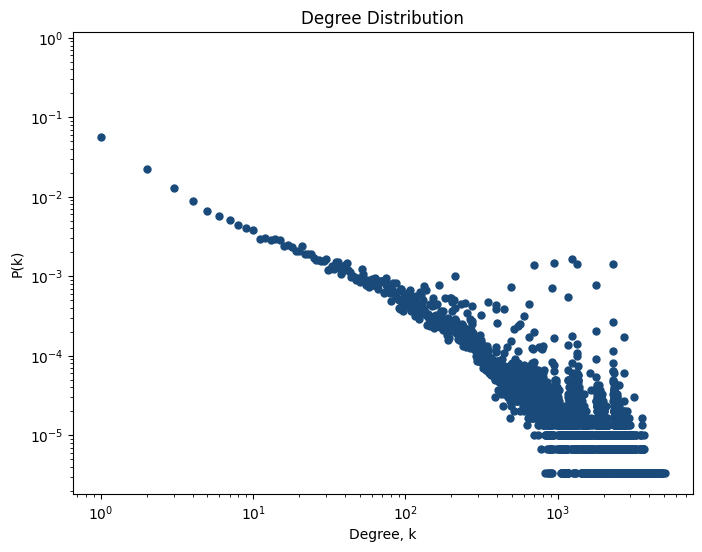

In [286]:
degree_sequence = [d for n, d in G.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.nonzero(degree_count)[0]

degree_prob = degree_count[degrees] / float(sum(degree_count))

plt.figure(figsize=(8, 6))
plt.loglog(degrees, degree_prob, 'o', markersize=5, color='#194a7a')
plt.title("Degree Distribution")
plt.xlabel("Degree, k")
plt.ylabel("P(k)")
plt.grid(False)
plt.savefig('Degree_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

<span style="font-weight:bold; font-size:20px;">Isolated nodes</span>

In [17]:
isolates = list(nx.isolates(G))
iso_comps = []
found_on = []
funding = []
rounds = []
startup = []
for i in range(len(unique_comps)):
    if unique_comps[i] in isolates:
        iso_comps.append(data[i]['name'])
        found_on.append((datetime.now() - datetime.strptime(data[i]['founded_on'], '%Y-%m-%d')).days)
        funding.append(data[i]['equity_funding_total_usd'])
        rounds.append(data[i]['num_funding_rounds'])
        startup.append(data[i]['startup'])
iso_df = pd.DataFrame({
    'company': iso_comps,
    'days_since_founded': found_on,
    'equity_funding_total_usd': funding,
    'num_funding_rounds': rounds,
    'startup': startup
})
iso_df['num_funding_rounds'] = iso_df['num_funding_rounds'].fillna(0)

NameError: name 'unique_comps' is not defined

In [79]:
# Use Random forests to judge feature importance
X = iso_df.drop(columns=['startup', 'company'])
y = iso_df['startup']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Feature combination
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = RandomForestClassifier(random_state=42)
model_poly.fit(X_train_poly, y_train)

# Performance
y_pred = model_poly.predict(X_test_poly)
print("Classification Report with Interaction Features:")
print(classification_report(y_test, y_pred))

<span style="font-weight:bold; font-size:20px;">Non-isolated nodes</span>

In [96]:
data_non_iso = [i for i in data if i['name'] not in isolates]

In [20]:
# Generate the feature dataframe
isolates = list(nx.isolates(G))
data_non_iso = [i for i in data if i['name'] not in isolates]
fea_df = generate_feature(G, data_non_iso)

In [21]:
# Caculate the class success rate and closeness
cla = {}
for i in data_non_iso:
    for n in i['category_groups']:
        if not n in cla.keys():
            cla[n] = 1
        else:
            cla[n] += 1
cla_success_rate = success_rate(data_non_iso, cla, 'category_groups')
cla_avg_closeness = {}
for i in cla.keys():
    for n in range(len(fea_df['node_id'])):
        if i in fea_df['categories'][n]:
            if i in cla_avg_closeness:
                cla_avg_closeness[i] += fea_df['closeness'][n]
            else:
                cla_avg_closeness[i] = fea_df['closeness'][n]
for i in cla_avg_closeness:
    cla_avg_closeness[i] = cla_avg_closeness[i]/cla[i]


avg_cla_sco = []
avg_cla_clo = []
for i in fea_df['categories']:
    cla_rates = [cla_success_rate[n] for n in i]
    clo_rates = [cla_avg_closeness[n] for n in i]
    if cla_rates:
        avg_success_rate = sum(cla_rates) / len(cla_rates)
        avg_clo = sum(clo_rates) / len(clo_rates)
        avg_cla_sco.append(avg_success_rate)
        avg_cla_clo.append(avg_clo)
    else:
        avg_cla_sco.append(0)
        avg_cla_clo.append(0)
fea_df['class_score'] = avg_cla_sco
fea_df['class_avg_closeness'] = avg_cla_clo

In [82]:
cla_df = pd.DataFrame(list(cla_success_rate.items()), columns=['Category', 'Success Rate'])

# 按成功率升序排序，并选择前十个类别
cla_lowest_success_rates = cla_df.sort_values(by='Success Rate').head(10)
cla_lowest_success_rates

,Category,Success Rate
48,Social Impact,0.433855
29,Lending and Investments,0.490034
31,Clothing and Apparel,0.507590
18,Education,0.512789
25,Media and Entertainment,0.516998
47,Music and Audio,0.517986
44,Video,0.518332
14,Manufacturing,0.542112
26,Gaming,0.542744
35,Events,0.543390


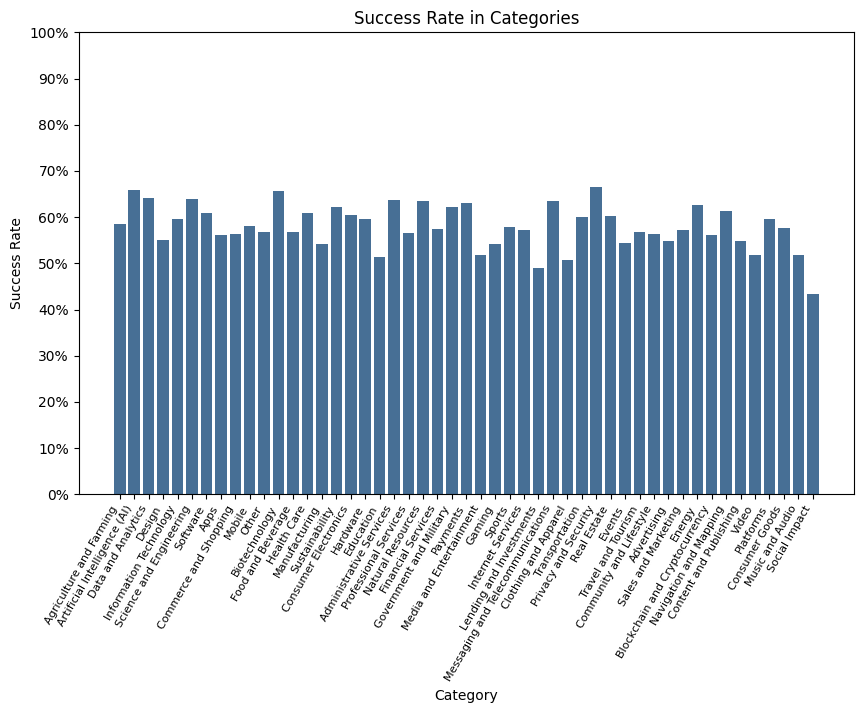

In [293]:
categories = list(cla_success_rate.keys())
cla_success_rates = list(cla_success_rate.values())

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(categories, cla_success_rates, color='#476f95')

# 添加标题和标签
plt.xlabel('Category')
plt.ylabel('Success Rate')
plt.title('Success Rate in Categories')

# 显示百分比格式的 y 轴标签
plt.yticks([i/10 for i in range(11)], [f'{i*10}%' for i in range(11)])
plt.xticks(rotation=60, ha='right', fontsize=8)

# 显示图表
plt.savefig('categories success rate.png', dpi=300, bbox_inches='tight')
plt.show()

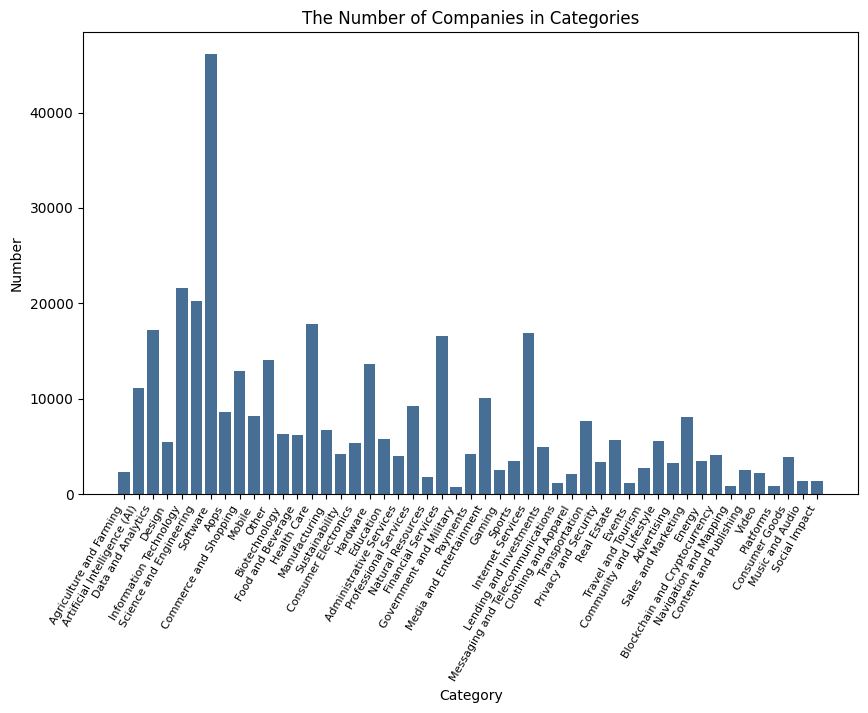

In [296]:
categories = list(cla.keys())
cla_success_rates = list(cla.values())

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(categories, cla_success_rates, color='#476f95')

# 添加标题和标签
plt.xlabel('Category')
plt.ylabel('Number')
plt.title('The Number of Companies in Categories')

# 显示百分比格式的 y 轴标签
#plt.yticks([i/10 for i in range(11)], [f'{i*10}%' for i in range(11)])
plt.xticks(rotation=60, ha='right', fontsize=8)

# 显示图表
plt.savefig('number in categories.png', dpi=300, bbox_inches='tight')
plt.show()

In [121]:
# Caculate the location success rate
location = {}
for i in data_non_iso:
    if i['location_groups']:
        for n in i['location_groups']:
            if not n in location:
                location[n] = 1
            else:
                location[n] += 1
loc_success_rate = success_rate(data_non_iso, location, 'location_groups')
avg_loc_sco = []
# for i in data_non_iso:
#     rates = [loc_success_rate[n] for n in i['location_groups']]
#     if rates:
#         avg_success_rate = sum(rates) / len(rates)
#         avg_loc_sco.append(avg_success_rate)
#     else:
#         avg_loc_sco.append(0)
for i in data_non_iso:
    num = [location[n] for n in i['location_groups']]
    if num:
        avg_num = sum(num) / len(num)
        avg_loc_sco.append(avg_num)
    else:
        avg_loc_sco.append(0)
fea_df['location_score'] = avg_loc_sco

In [83]:
loc_df = pd.DataFrame(list(loc_success_rate.items()), columns=['Category', 'Success Rate'])

# 按成功率升序排序，并选择前十个类别
loc_lowest_success_rates = loc_df.sort_values(by='Success Rate').head(10)
loc_lowest_success_rates

,Category,Success Rate
14,Asia-Pacific (APAC),0.376928
37,Latin America,0.474012
25,Middle East,0.533352
16,Southeast Asia,0.533432
15,Association of Southeast Asian Nations (ASEAN),0.533432
28,Gulf Cooperation Council (GCC),0.533643
41,Central America,0.540541
12,"Europe, Middle East, and Africa (EMEA)",0.545695
19,European Union (EU),0.576149
31,Australasia,0.588033


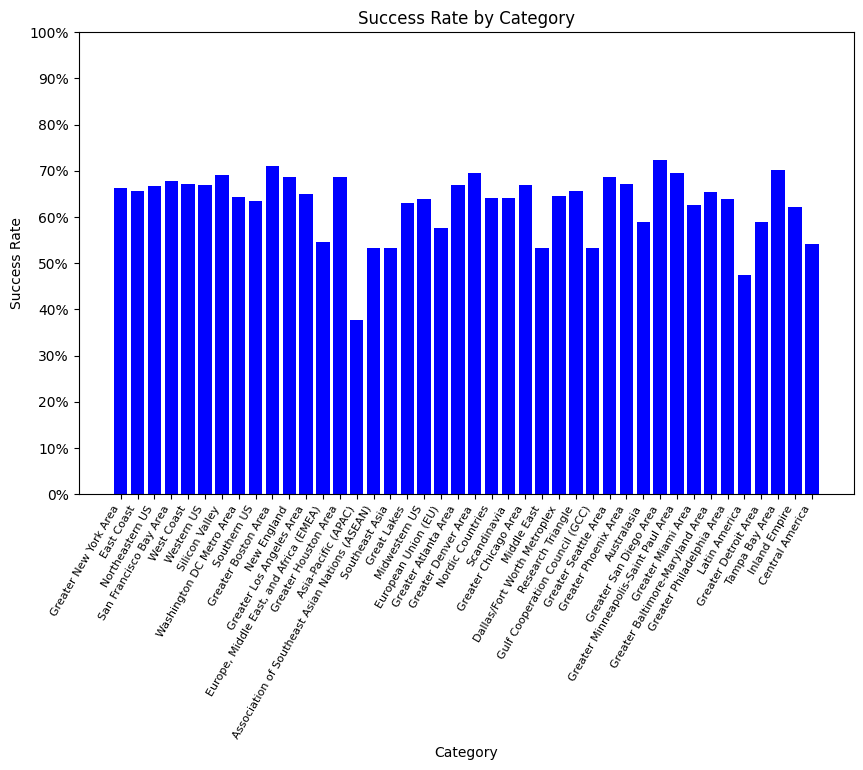

In [79]:
locations = list(loc_success_rate.keys())
loc_success_rates = list(loc_success_rate.values())

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(locations, loc_success_rates, color='blue')

# 添加标题和标签
plt.xlabel('Category')
plt.ylabel('Success Rate')
plt.title('Success Rate by Category')

# 显示百分比格式的 y 轴标签
plt.yticks([i/10 for i in range(11)], [f'{i*10}%' for i in range(11)])
plt.xticks(rotation=60, ha='right', fontsize=8)


# 显示图表
plt.show()

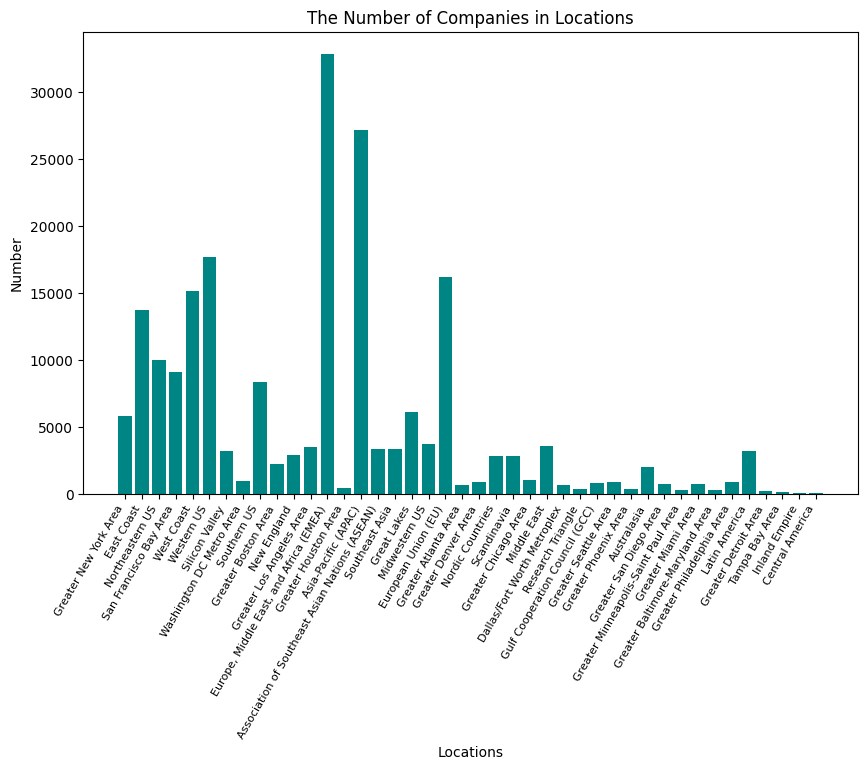

In [297]:
locations = list(location.keys())
loc_success_rates = list(location.values())

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(locations, loc_success_rates, color='#008585')

# 添加标题和标签
plt.xlabel('Locations')
plt.ylabel('Number')
plt.title('The Number of Companies in Locations')

# 显示百分比格式的 y 轴标签
plt.xticks(rotation=60, ha='right', fontsize=8)


# 显示图表
plt.savefig('number in locations.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Caculate the number of employees success rate
employees = {}
for i in data_non_iso:
    if i['num_employees_enum']:
        if not i['num_employees_enum'] in employees:
            employees[i['num_employees_enum']] = 1
        else:
            employees[i['num_employees_enum']] += 1
emp_success_rate = success_rate(data_non_iso, employees, 'num_employees_enum')
avg_emp_sco = []
for i in data_non_iso:
    if i['num_employees_enum']:
        avg_emp_sco.append(emp_success_rate[i['num_employees_enum']])
    else:
        avg_emp_sco.append(0)
fea_df['employees_score'] = avg_emp_sco

In [302]:
emp_success_rate

{'c_00101_00250': 0.7026445264452644,
 'c_00011_00050': 0.622150230882673,
 'c_01001_05000': 0.7870967741935484,
 'c_00251_00500': 0.7117408906882591,
 'c_00051_00100': 0.6585699623674307,
 'c_00501_01000': 0.7950963222416813,
 'c_00001_00010': 0.4591859132258615,
 'c_05001_10000': 0.7024793388429752,
 'c_10001_max': 0.7121212121212122}

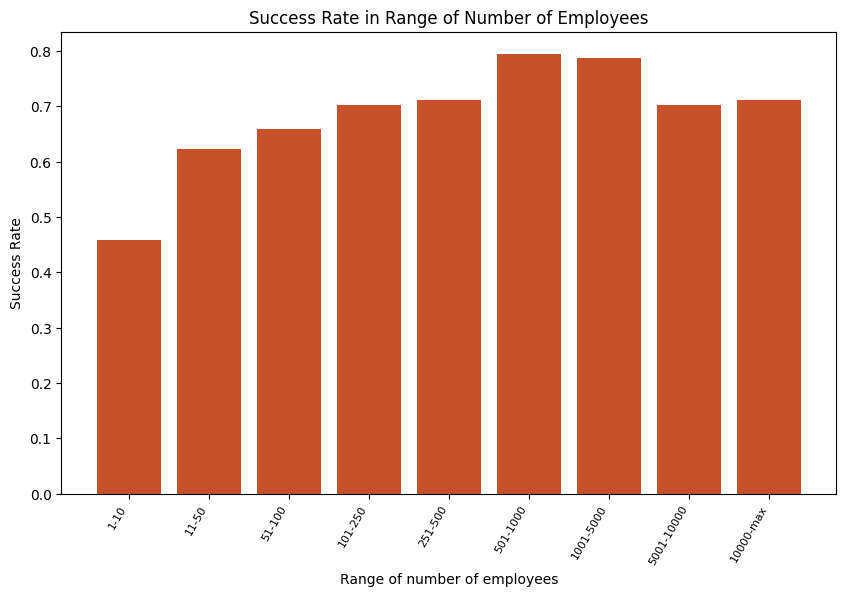

In [303]:
ranges_dict = {
    '1-10': 'c_00001_00010',
    '11-50': 'c_00011_00050',
    '51-100': 'c_00051_00100',
    '101-250': 'c_00101_00250',
    '251-500': 'c_00251_00500',
    '501-1000': 'c_00501_01000',
    '1001-5000': 'c_01001_05000',
    '5001-10000': 'c_05001_10000',
    '10000-max': 'c_10001_max'
}
emplo = list(ranges_dict.keys())
emp_success_rates = [emp_success_rate[i] for i in ranges_dict.values()]

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(emplo, emp_success_rates, color='#c7522a')

# 添加标题和标签
plt.xlabel('Range of number of employees')
plt.ylabel('Success Rate')
plt.title('Success Rate in Range of Number of Employees')

# 显示百分比格式的 y 轴标签
plt.xticks(rotation=60, ha='right', fontsize=8)


# 显示图表
plt.savefig('employees.png', dpi=300, bbox_inches='tight')
plt.show()

In [118]:
founders = {}
for i in data_non_iso:
    if i['founders']:
        for n in i['founders']:
            if not n in founders:
                founders[n] = 1
            else:
                founders[n] += 1
founders_data = []
for i in data_non_iso:
    if i['founders']:
        founders_sco = [founders[n] for n in i['founders']]
        founders_data.append(sum(founders_sco))
    else:
        founders_data.append(0)
fea_df['founders_score'] = founders_data

In [24]:
# Caculate component data
node_component_data = components_data(G)
comp_success_rate = [node_component_data[node]['component_success_rate'] for node in fea_df['node_id']]
comp_size = [node_component_data[node]['component_size'] for node in fea_df['node_id']]
comp_sco = [node_component_data[node]['component_score'] for node in fea_df['node_id']]
fea_df['component_success_rate'] = comp_success_rate
fea_df['component_size'] = comp_size
fea_df['component_score'] = comp_sco

In [57]:
# Caculate neighbors_data
neighbors_data = neighbors_score(G, fea_df['node_id'])
fea_df['neighbors_weighted_success'] = neighbors_data

In [122]:
fea_df

,node_id,degree,closeness,categories,class_score,class_avg_closeness,location_score,employees_score,component_success_rate,component_size,component_score,neighbors_weighted_success,founders_score
0,Gro Intelligence_0,292,0.109160,"[Agriculture and Farming, Artificial Intellige...",0.611413,0.085842,9874.333333,0.702645,0.564982,95026,0.001687,251.7,1
1,Squire_1,1886,0.119097,"[Apps, Commerce and Shopping, Mobile, Other, S...",0.576692,0.082606,9874.333333,0.702645,0.564982,95026,0.001687,1456.3,3
2,The EVERY Company_2,341,0.110263,"[Biotechnology, Food and Beverage, Health Care...",0.606155,0.088037,13979.666667,0.702645,0.564982,95026,0.001687,276.2,2
3,Groq_3,963,0.114926,"[Artificial Intelligence (AI), Consumer Electr...",0.624703,0.088110,11291.000000,0.702645,0.564982,95026,0.001687,847.8,1
4,Campus_4,222,0.106323,"[Education, Software]",0.560811,0.082744,16419.000000,0.622150,0.564982,95026,0.001687,182.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107397,Easy Resume_299962,1,0.073628,"[Administrative Services, Professional Service...",0.603543,0.081339,9874.333333,0.459186,0.564982,95026,0.001687,0.1,3
107398,Worth Wearing_299969,6,0.083942,"[Content and Publishing, Media and Entertainment]",0.532617,0.077744,24555.000000,0.459186,0.564982,95026,0.001687,6.0,1
107399,Right Start Newcomer Services_299972,19,0.000063,"[Education, Media and Entertainment, Software]",0.546207,0.081386,0.000000,0.459186,0.050000,20,0.050000,2.8,0
107400,OrangeNow_299980,3,0.084703,"[Commerce and Shopping, Food and Beverage, Int...",0.567230,0.080766,13979.666667,0.459186,0.564982,95026,0.001687,3.1,6


<span style="font-weight:bold; font-size:20px;">Training and prediction</span>

In [312]:
# Split the data
X = fea_df.drop(columns=['node_id', 'categories', 'component_success_rate', 'component_size'])
y = [i['startup'] for i in data_non_iso]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [313]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [354]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                      Feature  Importance
1                   closeness    0.182226
7  neighbors_weighted_success    0.155222
2                 class_score    0.129681
3         class_avg_closeness    0.127137
0                      degree    0.102402
4              location_score    0.094445
8              founders_score    0.075446
5             employees_score    0.067673
6             component_score    0.065768


In [325]:
importance_df = importance_df[importance_df['Feature'] != 'class_avg_closeness']
re_feature = ['Closeness Centrality','Neighbors Influence','Category Score','Degree Centrality','Location Score','Founder Score','Employee Score','Component Score']

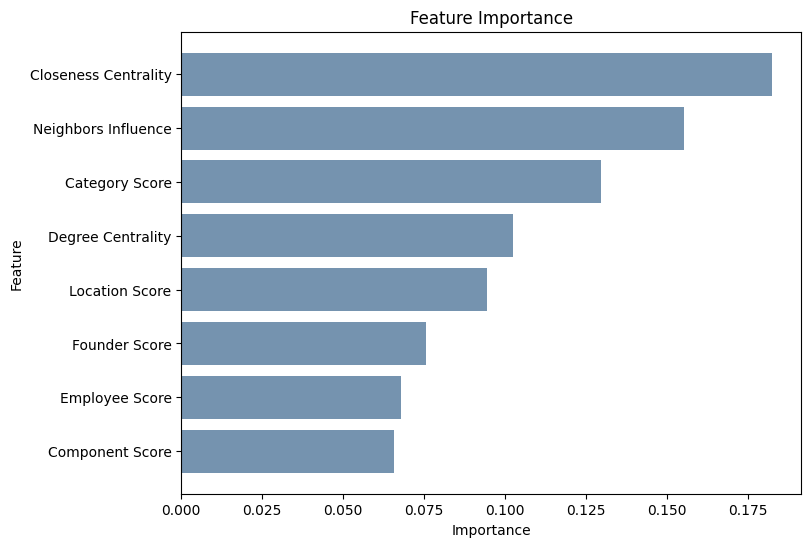

In [326]:
features = importance_df['Feature']
importances = importance_df['Importance']

# 创建条形图
plt.figure(figsize=(8, 6))
plt.barh(re_feature, importances, color='#7593af')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 将最高的重要性值显示在顶部
plt.savefig('feature_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [251]:
model_1 = LogisticRegression(class_weight='balanced', max_iter=10000)
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=300)
model_4 = SVC(kernel='rbf', gamma='scale', probability=True)
model_5 = KNeighborsClassifier(n_neighbors=3)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)
model_5.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(X_test)

In [252]:
evaluate_pred(model_1, X_test, y_test, y_pred_1, 'Logistic Regression')
evaluate_pred(model_2, X_test, y_test, y_pred_2, 'Decision Tree')
evaluate_pred(model_3, X_test, y_test, y_pred_3, 'Random Forest')
evaluate_pred(model_4, X_test, y_test, y_pred_4, 'SVC')
evaluate_pred(model_5, X_test, y_test, y_pred_5, 'K-Nearest Neighbors')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      failed       0.65      0.67      0.66      9725
     success       0.72      0.70      0.71     11756

    accuracy                           0.69     21481
   macro avg       0.68      0.68      0.68     21481
weighted avg       0.69      0.69      0.69     21481

Logistic Regression ROC AUC Score: 0.755
Decision Tree Classification Report:
              precision    recall  f1-score   support

      failed       0.64      0.64      0.64      9725
     success       0.70      0.70      0.70     11756

    accuracy                           0.67     21481
   macro avg       0.67      0.67      0.67     21481
weighted avg       0.67      0.67      0.67     21481

Decision Tree ROC AUC Score: 0.670
Random Forest Classification Report:
              precision    recall  f1-score   support

      failed       0.74      0.67      0.71      9725
     success       0.75      0.81      0.78 

In [253]:
y_pred_1_train = model_1.predict(X_train)
y_pred_2_train = model_2.predict(X_train)
y_pred_3_train = model_3.predict(X_train)
y_pred_4_train = model_4.predict(X_train)
y_pred_5_train = model_5.predict(X_train)

In [254]:
evaluate_pred(model_1, X_train, y_train, y_pred_1_train, 'Logistic Regression')
evaluate_pred(model_2, X_train, y_train, y_pred_2_train, 'Decision Tree')
evaluate_pred(model_3, X_train, y_train, y_pred_3_train, 'Random Forest')
evaluate_pred(model_4, X_train, y_train, y_pred_4_train, 'SVC')
evaluate_pred(model_5, X_train, y_train, y_pred_5_train, 'K-Nearest Neighbors')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      failed       0.65      0.66      0.65     39085
     success       0.71      0.70      0.71     46836

    accuracy                           0.68     85921
   macro avg       0.68      0.68      0.68     85921
weighted avg       0.68      0.68      0.68     85921

Logistic Regression ROC AUC Score: 0.751
Decision Tree Classification Report:
              precision    recall  f1-score   support

      failed       1.00      1.00      1.00     39085
     success       1.00      1.00      1.00     46836

    accuracy                           1.00     85921
   macro avg       1.00      1.00      1.00     85921
weighted avg       1.00      1.00      1.00     85921

Decision Tree ROC AUC Score: 1.000
Random Forest Classification Report:
              precision    recall  f1-score   support

      failed       0.82      0.73      0.77     39085
     success       0.79      0.86      0.83 

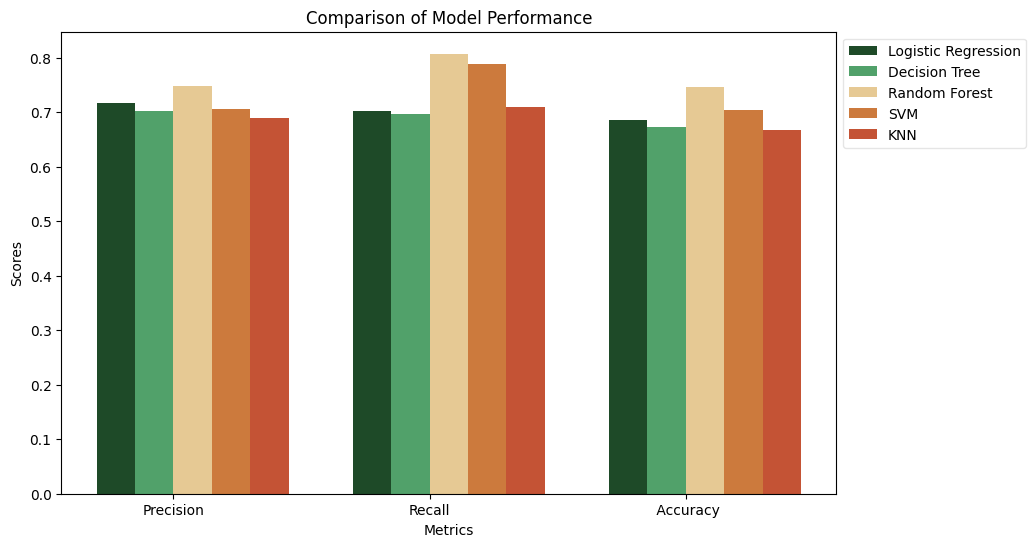

In [270]:
models = {model_1: {'name': 'Logistic Regression', 'color': '#1e4a28', 'train': y_pred_1_train, 'test': y_pred_1}, 
          model_2: {'name': 'Decision Tree', 'color': '#51a16a', 'train': y_pred_2_train, 'test': y_pred_2}, 
          model_3: {'name': 'Random Forest', 'color': '#e6c994', 'train': y_pred_3_train, 'test': y_pred_3}, 
          model_4: {'name': 'SVM', 'color': '#cc7a3d', 'train': y_pred_4_train, 'test': y_pred_4}, 
          model_5: {'name': 'KNN', 'color': '#c45335', 'train': y_pred_5_train, 'test': y_pred_5}}

# y_pred_proba_1 = model_1.predict_proba(X_test)[:, 1]
# y_pred_proba_2 = model_2.predict_proba(X_test)[:, 1]
# y_pred_proba_3 = model_3.predict_proba(X_test)[:, 1]
# y_pred_proba_4 = model_4.predict_proba(X_test)[:, 1]
# y_pred_proba_5 = model_5.predict_proba(X_test)[:, 1]

metrics_1 = [precision_score(y_test, y_pred_1, pos_label = 'success'), recall_score(y_test, y_pred_1, pos_label = 'success'), accuracy_score(y_test, y_pred_1)]
metrics_2 = [precision_score(y_test, y_pred_2, pos_label = 'success'), recall_score(y_test, y_pred_2, pos_label = 'success'), accuracy_score(y_test, y_pred_2)]
metrics_3 = [precision_score(y_test, y_pred_3, pos_label = 'success'), recall_score(y_test, y_pred_3, pos_label = 'success'), accuracy_score(y_test, y_pred_3)]
metrics_4 = [precision_score(y_test, y_pred_4, pos_label = 'success'), recall_score(y_test, y_pred_4, pos_label = 'success'), accuracy_score(y_test, y_pred_4)]
metrics_5 = [precision_score(y_test, y_pred_5, pos_label = 'success'), recall_score(y_test, y_pred_5, pos_label = 'success'), accuracy_score(y_test, y_pred_5)]

metrics_1_train = [precision_score(y_train, y_pred_1_train, pos_label = 'success'), recall_score(y_train, y_pred_1_train, pos_label = 'success'), accuracy_score(y_train, y_pred_1_train)]
metrics_2_train = [precision_score(y_train, y_pred_2_train, pos_label = 'success'), recall_score(y_train, y_pred_2_train, pos_label = 'success'), accuracy_score(y_train, y_pred_2_train)]
metrics_3_train = [precision_score(y_train, y_pred_3_train, pos_label = 'success'), recall_score(y_train, y_pred_3_train, pos_label = 'success'), accuracy_score(y_train, y_pred_3_train)]
metrics_4_train = [precision_score(y_train, y_pred_4_train, pos_label = 'success'), recall_score(y_train, y_pred_4_train, pos_label = 'success'), accuracy_score(y_train, y_pred_4_train)]
metrics_5_train = [precision_score(y_train, y_pred_5_train, pos_label = 'success'), recall_score(y_train, y_pred_5_train, pos_label = 'success'), accuracy_score(y_train, y_pred_5_train)]


metrics_names = ['Precision', 'Recall', ' Accuracy']
index = np.arange(len(metrics_names))

bar_width = 0.15

plt.figure(figsize=(10, 6))
plt.bar(index, metrics_1, bar_width, label='Logistic Regression', color='#1e4a28')
plt.bar(index + bar_width, metrics_2, bar_width, label='Decision Tree', color='#51a16a')
plt.bar(index + 2 * bar_width, metrics_3, bar_width, label='Random Forest', color='#e6c994')
plt.bar(index + 3 * bar_width, metrics_4, bar_width, label='SVM', color='#cc7a3d')
plt.bar(index + 4 * bar_width, metrics_5, bar_width, label='KNN', color='#c45335')


plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(index + 1.5 * bar_width, metrics_names)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), framealpha=0.5)
plt.savefig('Model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [336]:
metrics_3

[0.7484628724578275, 0.8076726777815584, 0.7461943112518039]

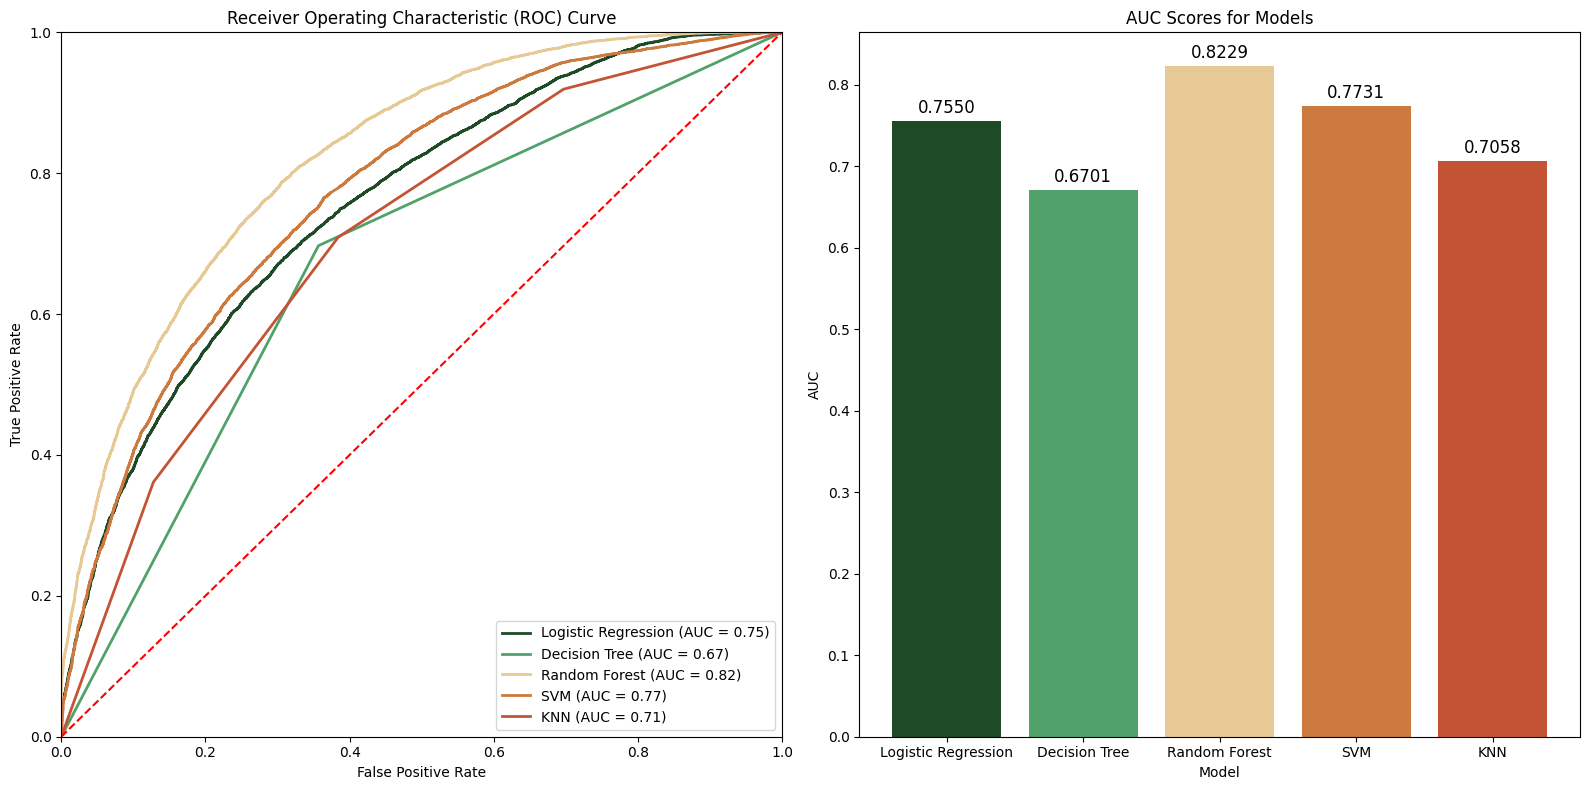

In [363]:
auc_scores = {}
colors = []

# 创建一个包含两个子图的画布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 绘制 ROC 曲线
for model, model_info in models.items():
    model_name = model_info['name']
    model_color = model_info['color']
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # 获取阳性类的预测概率
    
    # 计算 FPR 和 TPR
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='success')
    
    # 计算 AUC
    roc_auc = auc(fpr, tpr)
    auc_scores[model_name] = roc_auc
    colors.append(model_color)
    
    # 在第一个子图（ax1）中绘制 ROC 曲线
    ax1.plot(fpr, tpr, color=model_color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# 绘制对角线（随机猜测）
ax1.plot([0, 1], [0, 1], color='red', linestyle='--')

# ROC 曲线图表设置
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc='lower right')

# 在第二个子图（ax2）中绘制 AUC 柱状图
ax2.bar(auc_scores.keys(), auc_scores.values(), color=colors)

# AUC 柱状图设置
ax2.set_xlabel('Model')
ax2.set_ylabel('AUC')
ax2.set_title('AUC Scores for Models')

# 显示数值在柱状图上
for i, v in enumerate(auc_scores.values()):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)

# 调整布局并保存图表
plt.tight_layout()
plt.savefig('ROC-AUC.png', dpi=300, bbox_inches='tight')
plt.show()

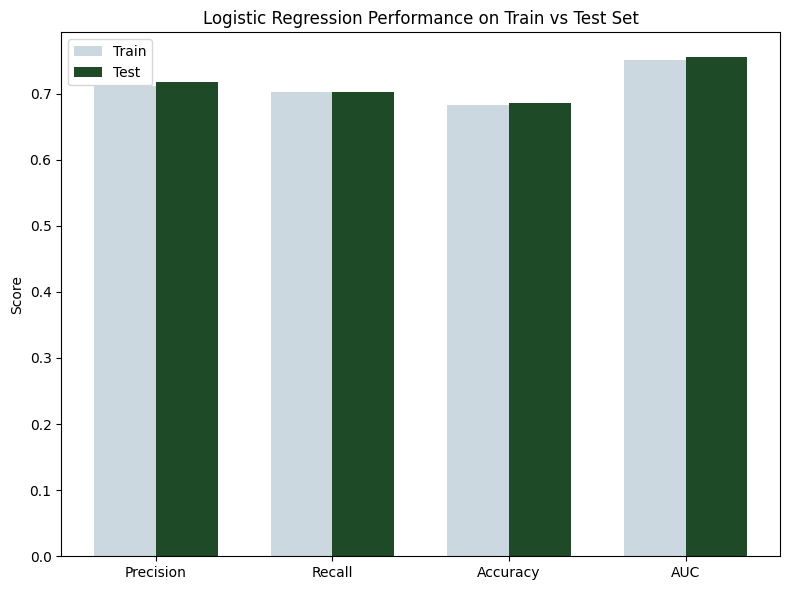

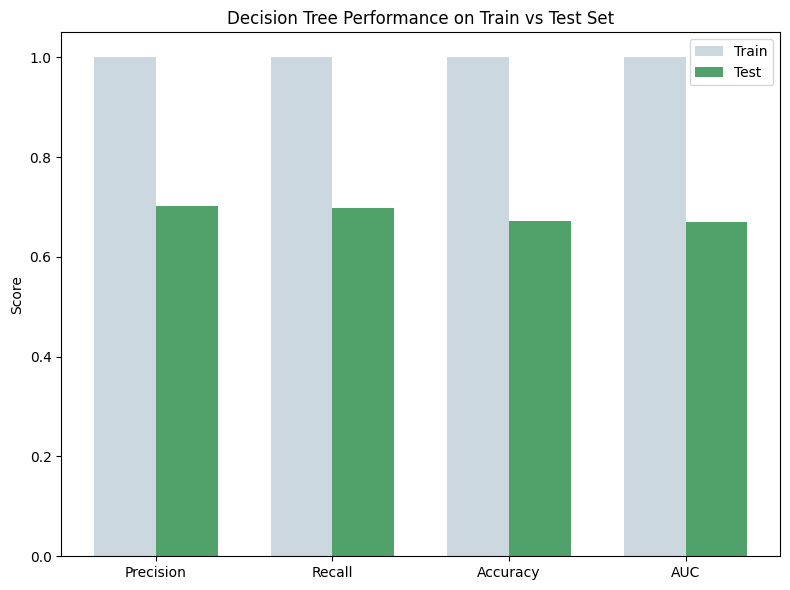

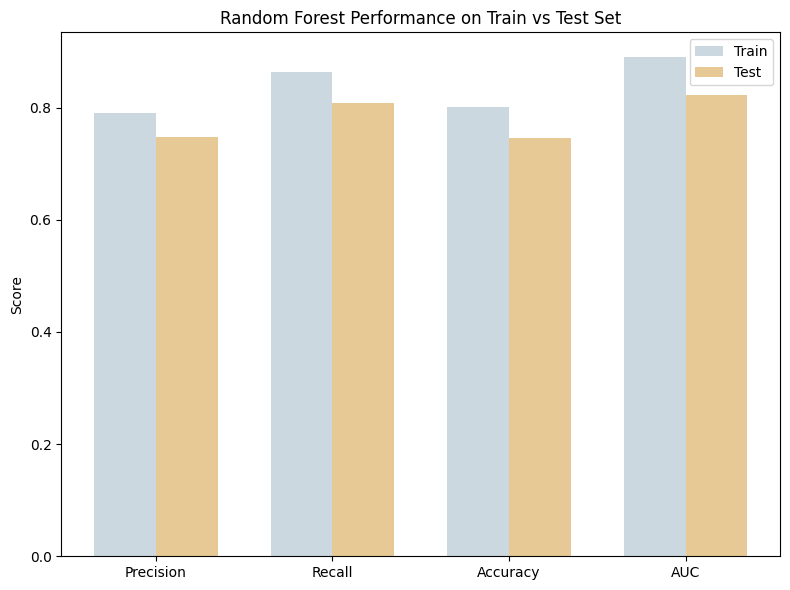

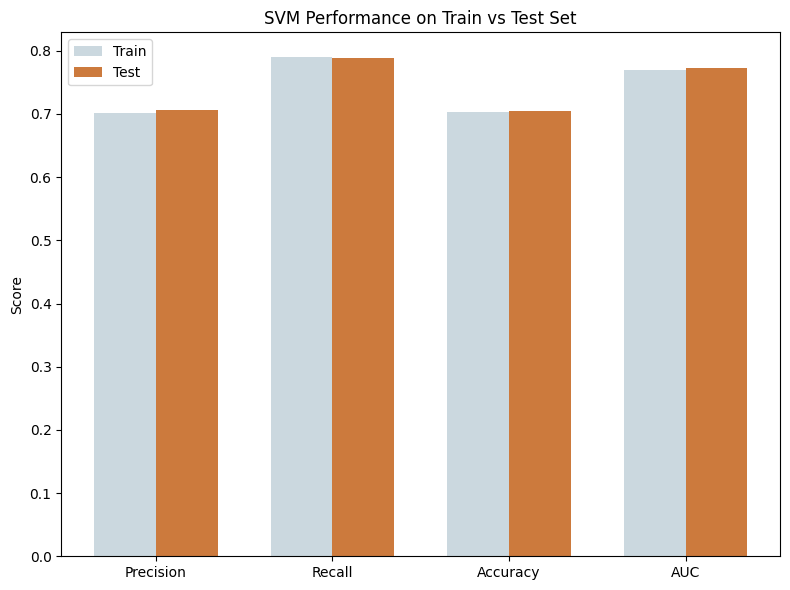

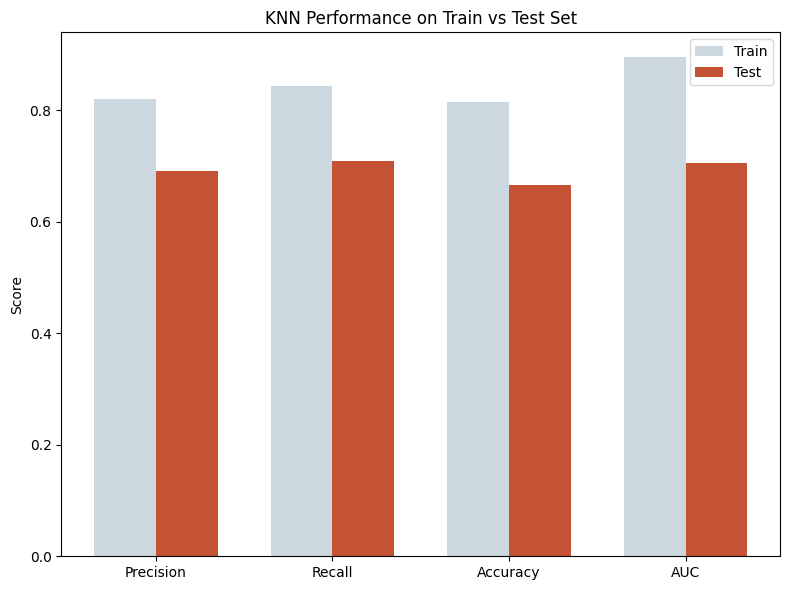

In [272]:
metrics_names = ['Precision', 'Recall', 'Accuracy', 'AUC']

# 计算每个模型的指标并存储
for model, model_info in models.items():
    name = model_info['name']
    color = model_info['color']
    y_train_pred = model_info['train']
    y_test_pred = model_info['test']
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # 计算训练集上的指标
    precision_train = precision_score(y_train, y_train_pred, pos_label = 'success')
    recall_train = recall_score(y_train, y_train_pred, pos_label = 'success')
    accuracy_train = accuracy_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train, pos_label = 'success')
    auc_train = auc(fpr_train, tpr_train)
    
    # 计算测试集上的指标
    precision_test = precision_score(y_test, y_test_pred, pos_label = 'success')
    recall_test = recall_score(y_test, y_test_pred, pos_label = 'success')
    accuracy_test = accuracy_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test, pos_label = 'success')
    auc_test = auc(fpr_test, tpr_test)
    
    # 存储指标
    train_values = [precision_train, recall_train, accuracy_train, auc_train]
    test_values = [precision_test, recall_test, accuracy_test, auc_test]
    
    # 绘制每个模型的图表
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    x = range(len(metrics_names))  # 4个指标
    width = 0.35  # 柱的宽度
    
    ax.bar([p - width/2 for p in x], train_values, width, label='Train', color='#cbd8df')
    ax.bar([p + width/2 for p in x], test_values, width, label='Test', color=color)
    
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.set_ylabel('Score')
    ax.set_title(f'{name} Performance on Train vs Test Set')
    ax.legend()

    plt.tight_layout()
    plt.show()

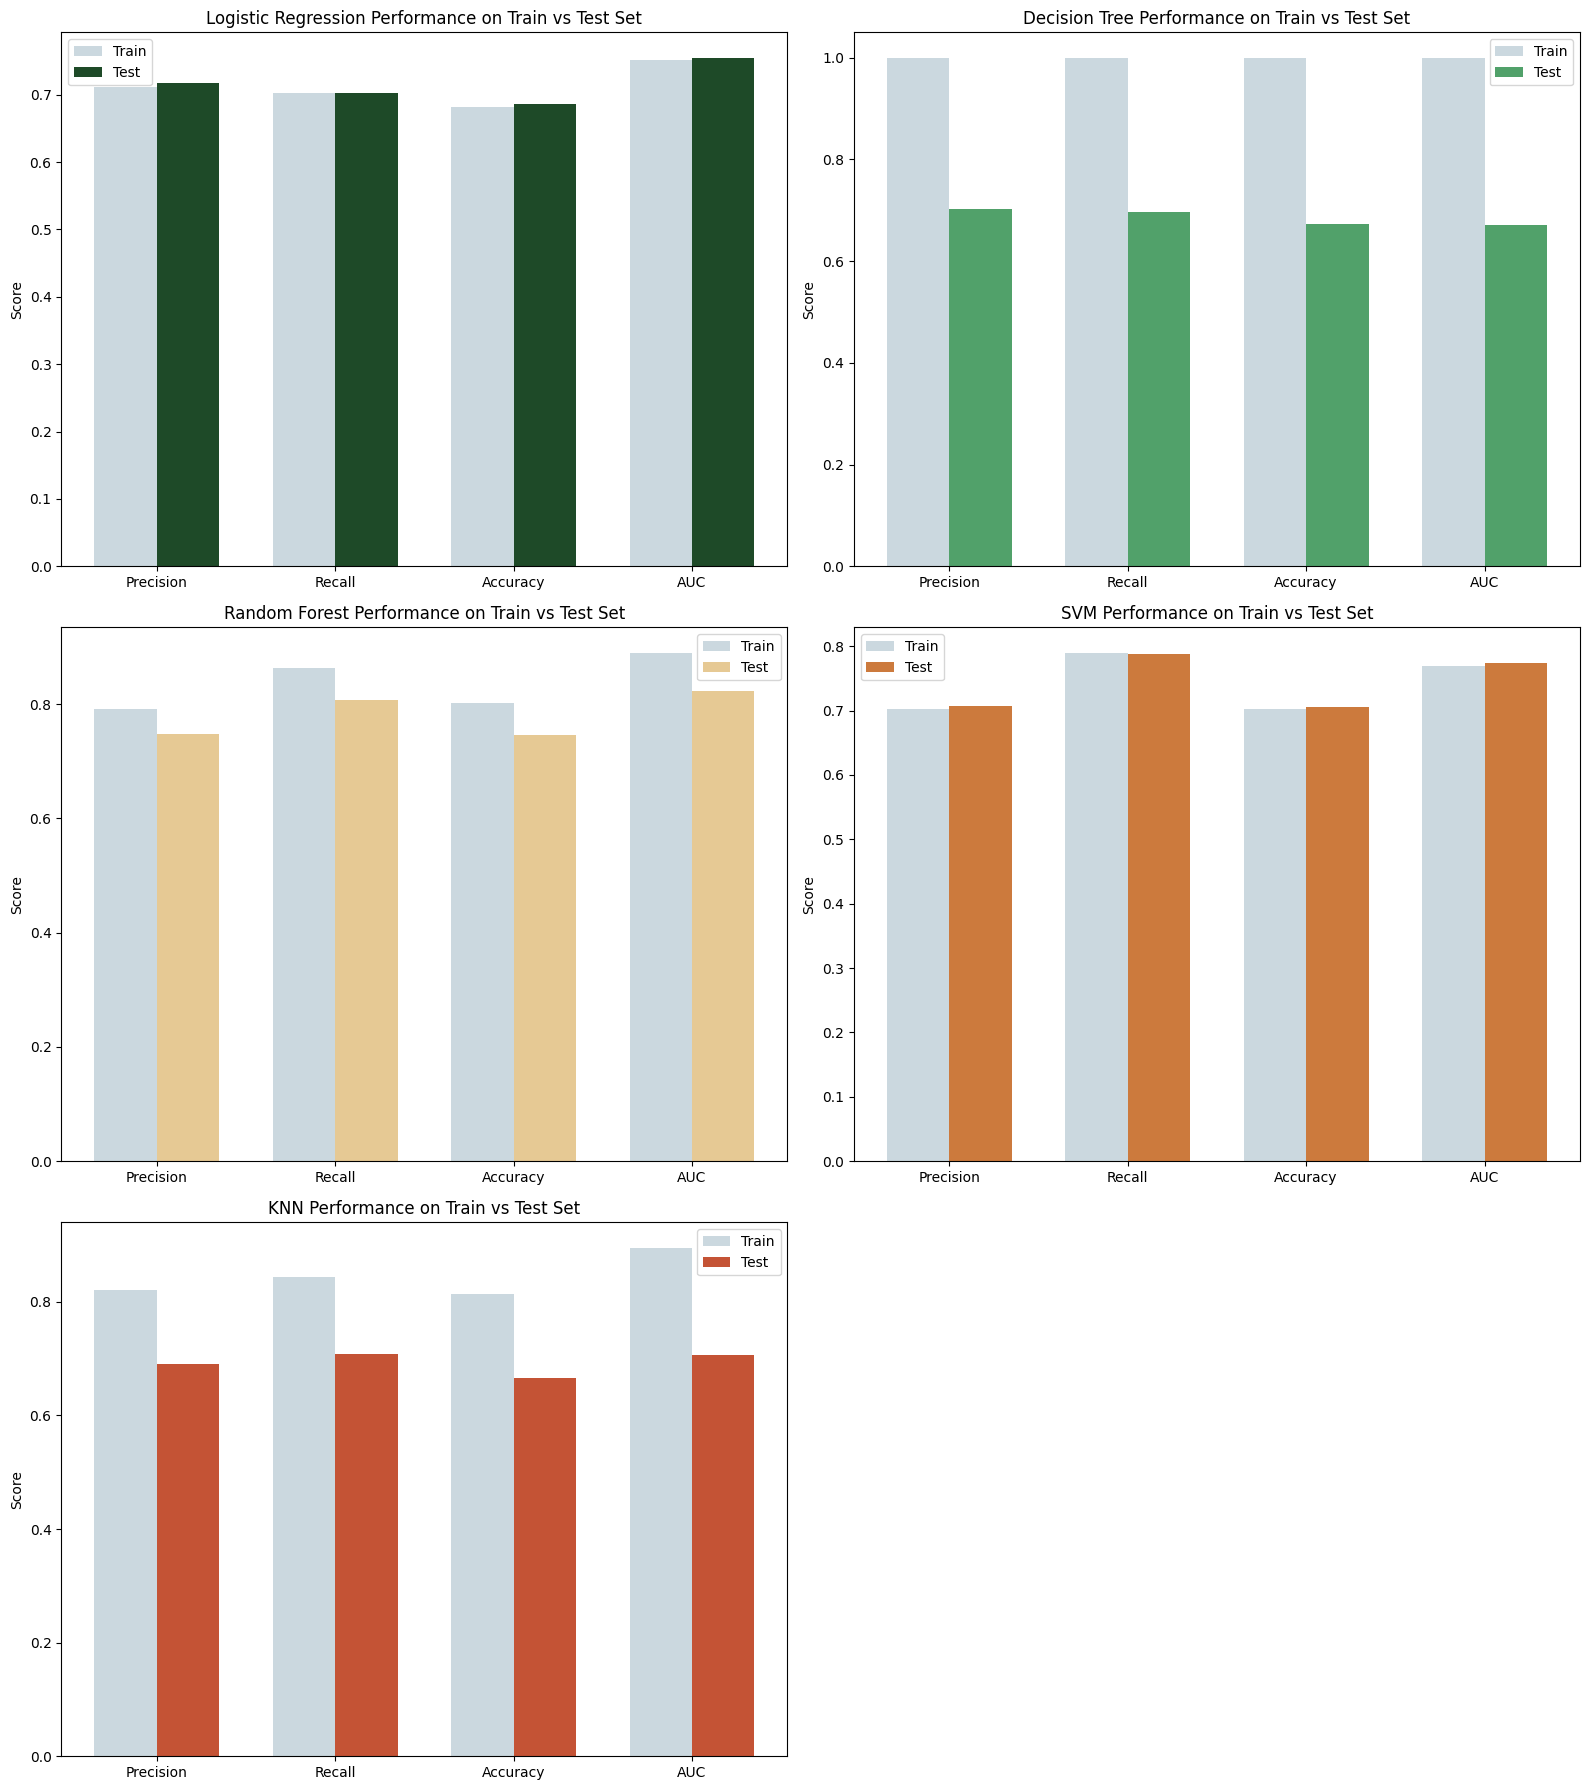

In [330]:
import matplotlib.pyplot as plt

metrics_names = ['Precision', 'Recall', 'Accuracy', 'AUC']

# 确定子图的行和列数
n_models = len(models)
n_cols = 2  # 每行两个子图
n_rows = (n_models + 1) // n_cols  # 确定行数，使用整除法
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))

# 将 axs 转换为二维数组，便于统一处理
axs = axs.flatten()

# 计算每个模型的指标并存储
for i, (model, model_info) in enumerate(models.items()):
    name = model_info['name']
    color = model_info['color']
    y_train_pred = model_info['train']
    y_test_pred = model_info['test']
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # 计算训练集上的指标
    precision_train = precision_score(y_train, y_train_pred, pos_label='success')
    recall_train = recall_score(y_train, y_train_pred, pos_label='success')
    accuracy_train = accuracy_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train, pos_label='success')
    auc_train = auc(fpr_train, tpr_train)
    
    # 计算测试集上的指标
    precision_test = precision_score(y_test, y_test_pred, pos_label='success')
    recall_test = recall_score(y_test, y_test_pred, pos_label='success')
    accuracy_test = accuracy_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test, pos_label='success')
    auc_test = auc(fpr_test, tpr_test)
    
    # 存储指标
    train_values = [precision_train, recall_train, accuracy_train, auc_train]
    test_values = [precision_test, recall_test, accuracy_test, auc_test]
    
    # 当前子图位置
    ax = axs[i]
    x = range(len(metrics_names))  # 4个指标
    width = 0.35  # 柱的宽度
    
    ax.bar([p - width/2 for p in x], train_values, width, label='Train', color='#cbd8df')
    ax.bar([p + width/2 for p in x], test_values, width, label='Test', color=color)
    
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.set_ylabel('Score')
    ax.set_title(f'{name} Performance on Train vs Test Set')
    ax.legend()

# 删除可能多余的子图
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# 调整整体布局
plt.tight_layout()

# 显示图表
plt.savefig('train and test.png', dpi=300, bbox_inches='tight')
plt.show()


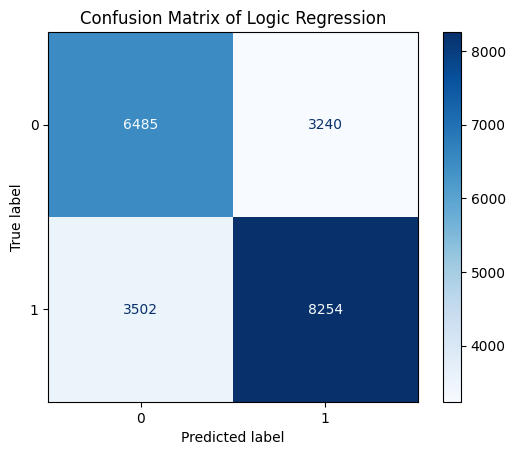

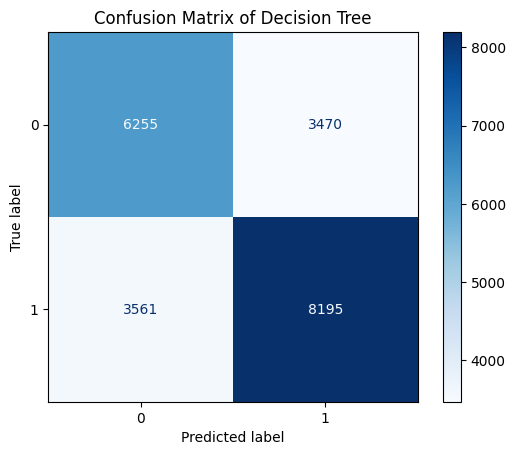

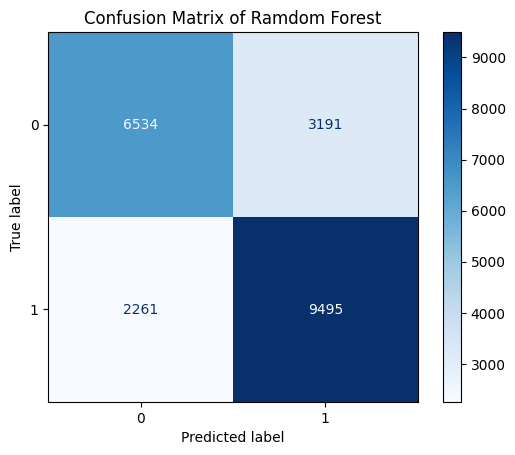

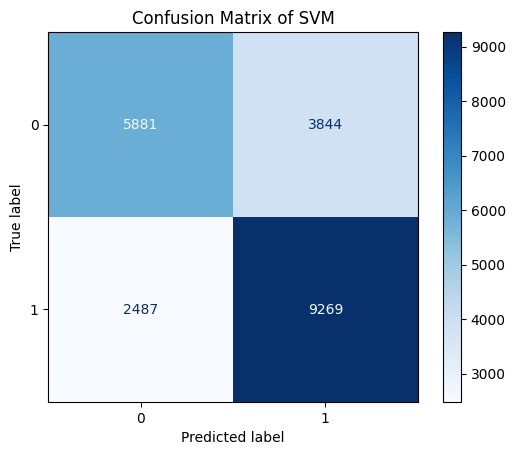

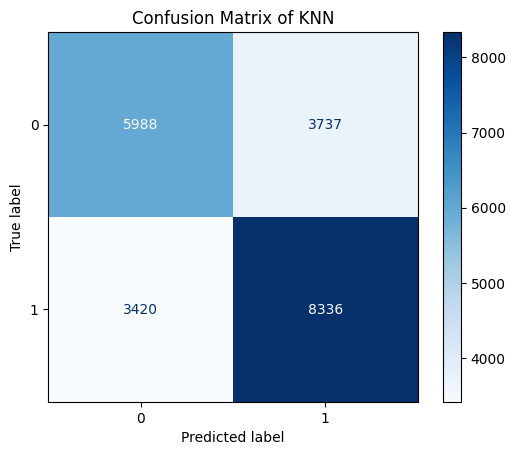

In [274]:
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_2 = confusion_matrix(y_test, y_pred_2)
cm_3 = confusion_matrix(y_test, y_pred_3)
cm_4 = confusion_matrix(y_test, y_pred_4)
cm_5 = confusion_matrix(y_test, y_pred_5)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_1)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Logic Regression')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Decision Tree')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_3)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Ramdom Forest')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_4)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of SVM')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_5)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of KNN')
plt.show()

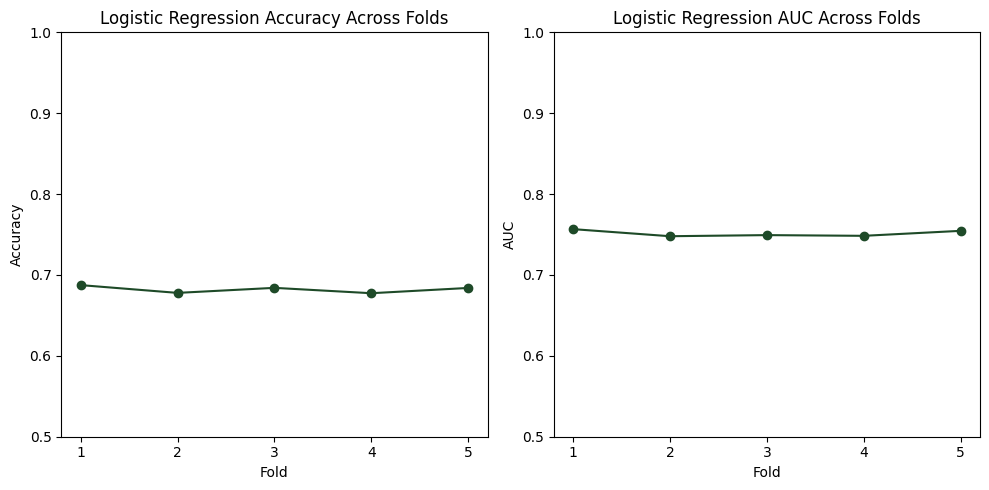

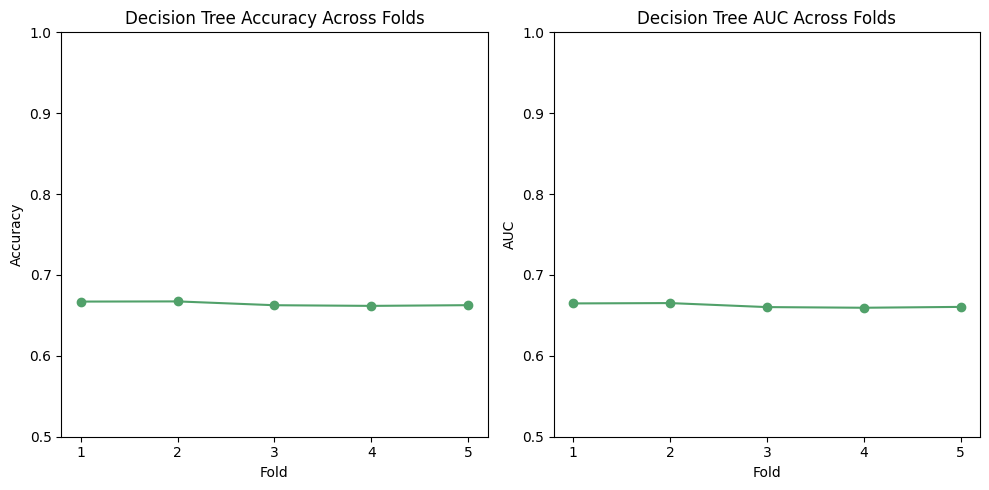

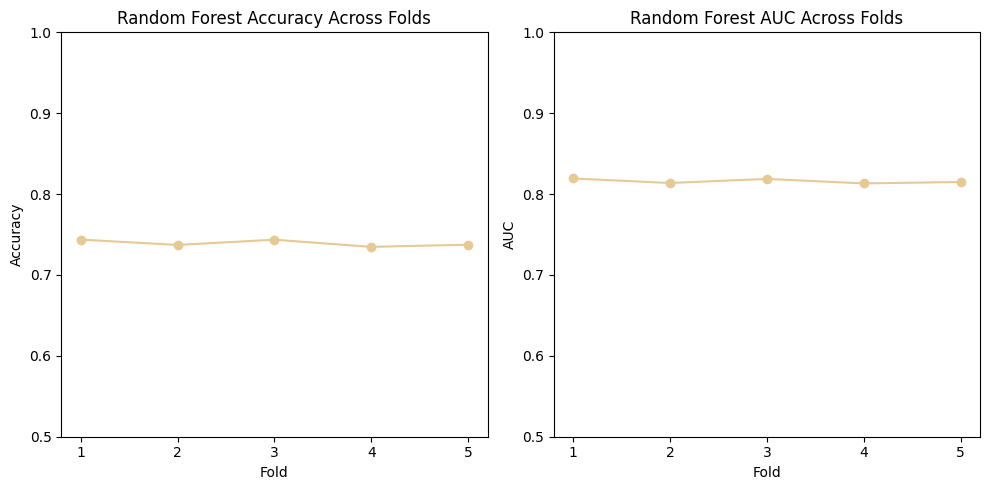

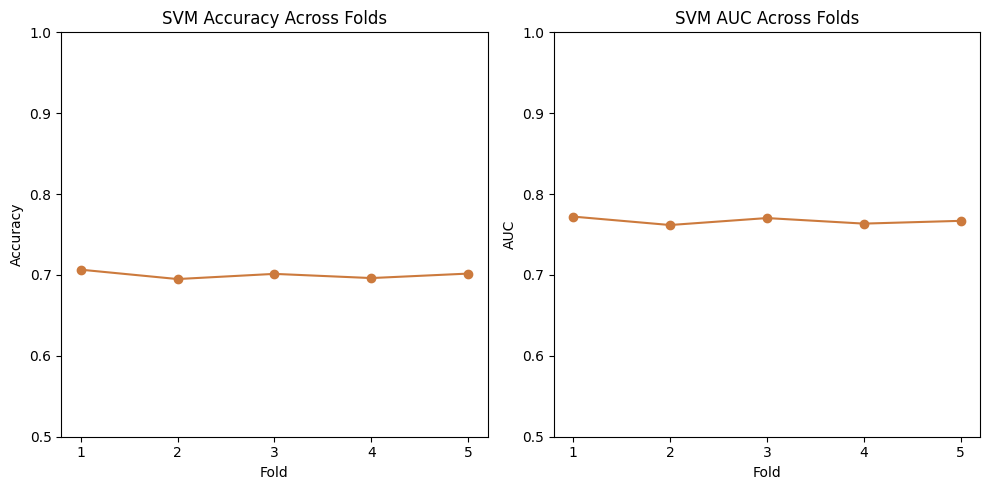

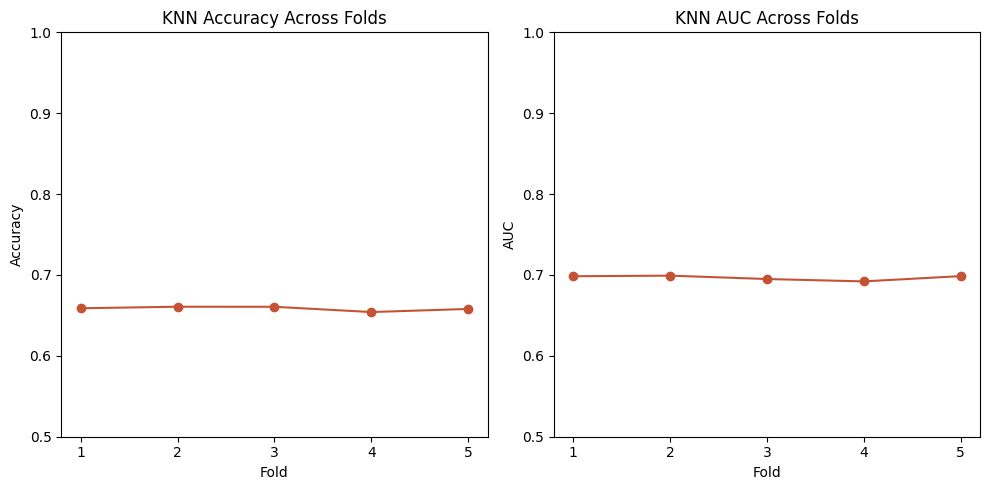

Model: Logistic Regression
  Accuracy Mean: 0.6821 ± 0.0039
  AUC Mean: 0.7514 ± 0.0036

Model: Decision Tree
  Accuracy Mean: 0.6643 ± 0.0024
  AUC Mean: 0.6621 ± 0.0025

Model: Random Forest
  Accuracy Mean: 0.7393 ± 0.0037
  AUC Mean: 0.8160 ± 0.0026

Model: SVM
  Accuracy Mean: 0.7001 ± 0.0042
  AUC Mean: 0.7669 ± 0.0039

Model: KNN
  Accuracy Mean: 0.6585 ± 0.0024
  AUC Mean: 0.6966 ± 0.0027



In [284]:
# 交叉验证配置
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化结果存储字典
cv_results = {
    'Model': [],
    'Accuracy_Mean': [],
    'Accuracy_Std': [],
    'AUC_Mean': [],
    'AUC_Std': []
}

# 进行交叉验证
for model, model_info in models.items():
    if not model_info['name'] == 'Decision Tree'
        model_name = model_info['name']
        color = model_info['color']
        
        # 使用cross_validate执行交叉验证
        scores = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc'], return_train_score=False)
        
        # 计算Accuracy和AUC的均值和标准差
        accuracy_mean = np.mean(scores['test_accuracy'])
        accuracy_std = np.std(scores['test_accuracy'])
        auc_mean = np.mean(scores['test_roc_auc'])
        auc_std = np.std(scores['test_roc_auc'])
        
        # 存储结果
        cv_results['Model'].append(model_name)
        cv_results['Accuracy_Mean'].append(accuracy_mean)
        cv_results['Accuracy_Std'].append(accuracy_std)
        cv_results['AUC_Mean'].append(auc_mean)
        cv_results['AUC_Std'].append(auc_std)
        
        # 绘制Accuracy和AUC的变化曲线
        plt.figure(figsize=(10, 5))
        
        # Accuracy变化曲线
        plt.subplot(1, 2, 1)
        plt.plot(scores['test_accuracy'], marker='o', color=color)
        plt.title(f'{model_name} Accuracy Across Folds')
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])
        plt.yticks(np.arange(0.5, 1.05, 0.1))
    
    # AUC变化曲线
    # plt.subplot(1, 2, 2)
    # plt.plot(scores['test_roc_auc'], marker='o', color=color)
    # plt.title(f'{model_name} AUC Across Folds')
    # plt.xlabel('Fold')
    # plt.ylabel('AUC')
    # plt.xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])
    # plt.yticks(np.arange(0.5, 1.05, 0.1))
    
    # plt.tight_layout()
    # plt.show()

# 输出每个模型的平均值和标准差
for i in range(len(cv_results['Model'])):
    print(f"Model: {cv_results['Model'][i]}")
    print(f"  Accuracy Mean: {cv_results['Accuracy_Mean'][i]:.4f} ± {cv_results['Accuracy_Std'][i]:.4f}")
    print(f"  AUC Mean: {cv_results['AUC_Mean'][i]:.4f} ± {cv_results['AUC_Std'][i]:.4f}")
    print()

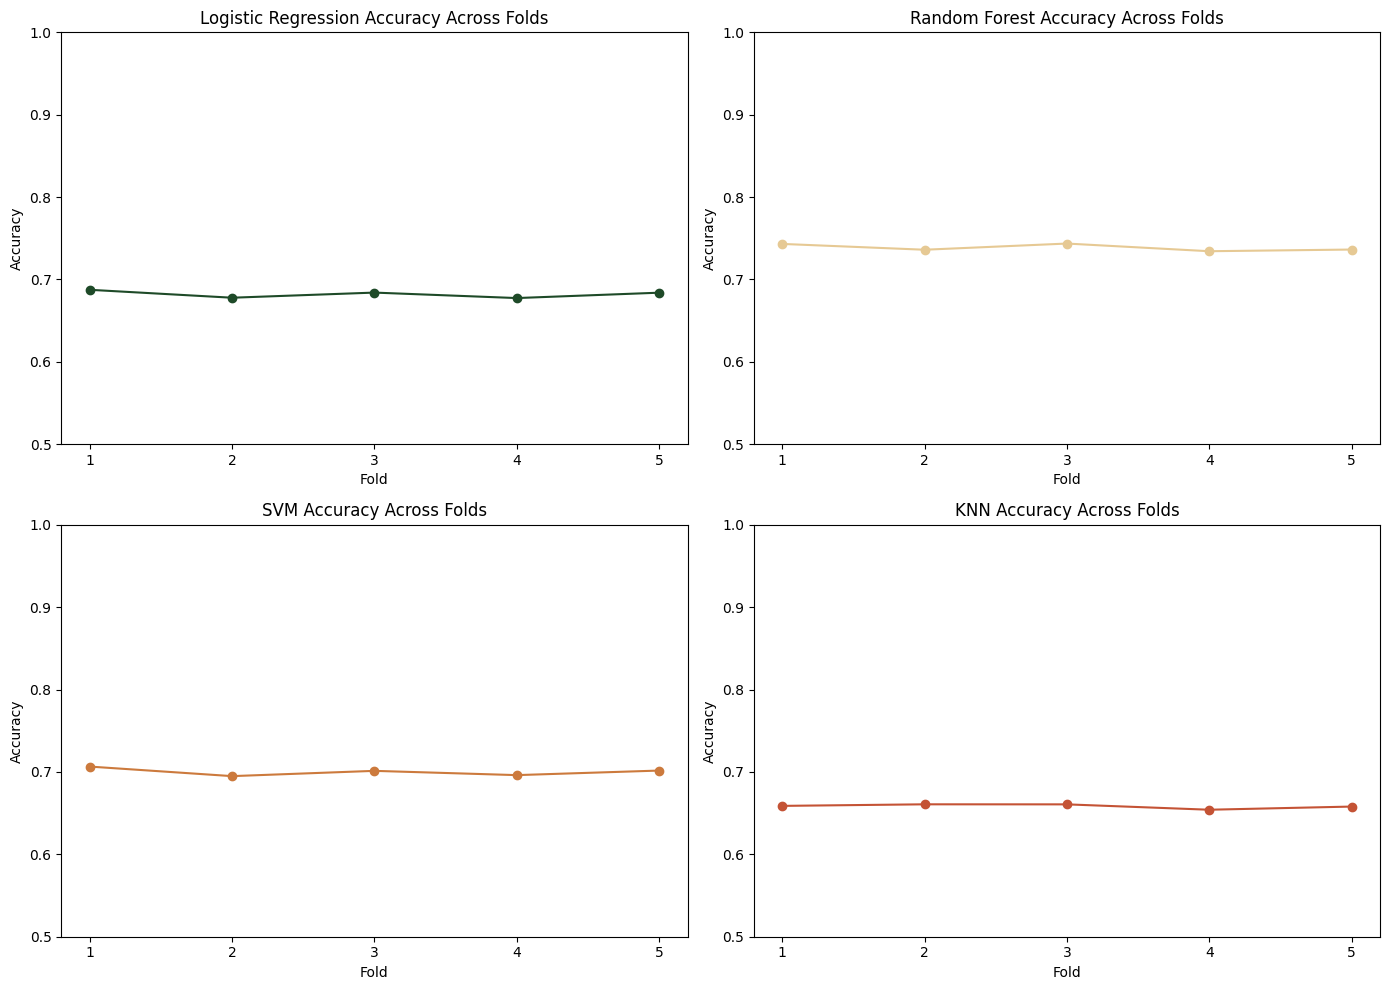

Model: Logistic Regression
  Accuracy Mean: 0.6821 ± 0.0039
  AUC Mean: 0.7514 ± 0.0036

Model: Random Forest
  Accuracy Mean: 0.7387 ± 0.0039
  AUC Mean: 0.8159 ± 0.0028

Model: SVM
  Accuracy Mean: 0.7001 ± 0.0042
  AUC Mean: 0.7669 ± 0.0039

Model: KNN
  Accuracy Mean: 0.6585 ± 0.0024
  AUC Mean: 0.6966 ± 0.0027



In [335]:

# 交叉验证配置
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化结果存储字典
cv_results = {
    'Model': [],
    'Accuracy_Mean': [],
    'Accuracy_Std': [],
    'AUC_Mean': [],
    'AUC_Std': []
}

# 创建子图
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # 2行2列布局
index = 0
# 进行交叉验证
for model, model_info in models.items():
    if model_info['name'] != 'Decision Tree':  # 忽略决策树模型
        model_name = model_info['name']
        color = model_info['color']
        
        # 使用cross_validate执行交叉验证
        scores = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc'], return_train_score=False)
        
        # 计算Accuracy和AUC的均值和标准差
        accuracy_mean = np.mean(scores['test_accuracy'])
        accuracy_std = np.std(scores['test_accuracy'])
        auc_mean = np.mean(scores['test_roc_auc'])
        auc_std = np.std(scores['test_roc_auc'])
        
        # 存储结果
        cv_results['Model'].append(model_name)
        cv_results['Accuracy_Mean'].append(accuracy_mean)
        cv_results['Accuracy_Std'].append(accuracy_std)
        cv_results['AUC_Mean'].append(auc_mean)
        cv_results['AUC_Std'].append(auc_std)
        
        # 绘制Accuracy变化曲线在适当的子图上
        ax = axs[index // 2, index % 2]  # 确定子图的位置
        ax.plot(scores['test_accuracy'], marker='o', color=color)
        ax.set_title(f'{model_name} Accuracy Across Folds')
        ax.set_xlabel('Fold')
        ax.set_ylabel('Accuracy')
        ax.set_xticks([0, 1, 2, 3, 4])
        ax.set_xticklabels(['1', '2', '3', '4', '5'])
        ax.set_yticks(np.arange(0.5, 1.05, 0.1))
        index += 1

# 调整整体布局
plt.tight_layout()

# 显示图表
plt.savefig('Cross validation.png', dpi=300, bbox_inches='tight')
plt.show()

# 输出每个模型的平均值和标准差
for i in range(len(cv_results['Model'])):
    print(f"Model: {cv_results['Model'][i]}")
    print(f"  Accuracy Mean: {cv_results['Accuracy_Mean'][i]:.4f} ± {cv_results['Accuracy_Std'][i]:.4f}")
    print(f"  AUC Mean: {cv_results['AUC_Mean'][i]:.4f} ± {cv_results['AUC_Std'][i]:.4f}")
    print()


In [333]:
scores

{'fit_time': array([0.04361176, 0.03967071, 0.03791404, 0.03819013, 0.03730297]),
 'score_time': array([0.82027698, 0.81357718, 0.80264401, 0.75496101, 0.75709581]),
 'test_accuracy': array([0.65883038, 0.66073091, 0.66067272, 0.65415503, 0.65799581]),
 'test_roc_auc': array([0.69841746, 0.6991748 , 0.69499486, 0.69204864, 0.69858082])}

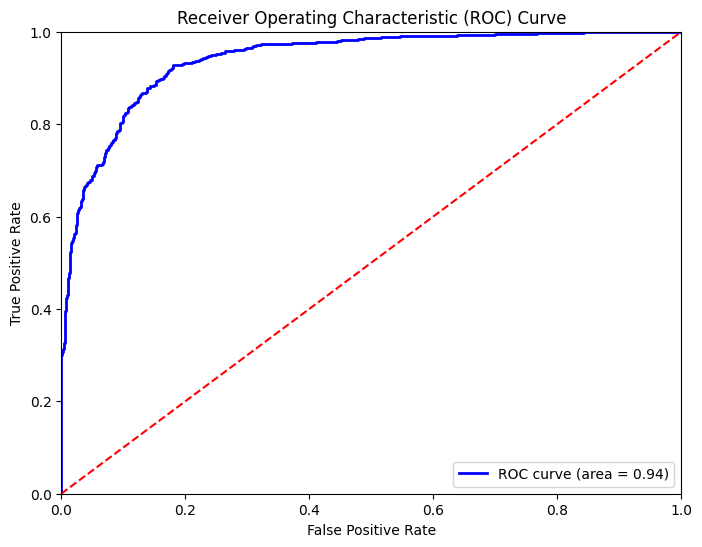

In [305]:
X, y = make_classification(n_samples=5000, n_features=20, n_classes=2, random_state=42)

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练一个随机森林模型
model = LogisticRegression()
model.fit(X_train, y_train)

# 计算预测概率
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 计算FPR, TPR, 和阈值
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('typical ROC.png', dpi=300, bbox_inches='tight')
plt.show()

In [199]:
scoring = ['accuracy', 'roc_auc']
scores = cross_validate(model_3, X, y, cv=5, scoring=scoring)

# 输出结果
print("Cross-Validation Accuracy:", scores['test_accuracy'])
print("Cross-Validation AUC:", scores['test_roc_auc'])

Cross-Validation Accuracy: [0.68944649 0.75089614 0.73365922 0.69958101 0.69934823]
Cross-Validation AUC: [0.82388202 0.84091955 0.80348626 0.78309431 0.82001677]


In [200]:
print("Average Accuracy:", scores['test_accuracy'].mean())
print("Average AUC:", scores['test_roc_auc'].mean())

Average Accuracy: 0.714586216549084
Average AUC: 0.814279783243057


In [285]:
len(G.nodes())

300001

In [365]:
# 创建一个空列表存储结果
results = []

# 初始所有特征训练模型
# X_val = fea_df.drop(columns=['node_id', 'categories', 'component_success_rate', 'component_size'])
# y_val = y
# X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)
# scaler = StandardScaler()
# X_val_train = scaler.fit_transform(X_val_train)
# X_val_test = scaler.transform(X_val_test)

# model = RandomForestClassifier(random_state=42)
# model.fit(X_val_train, y_val_train)
# y_val_pred = model.predict(X_val_test)
# y_val_pred_proba = model.predict_proba(X_val_test)[:, 1]
# fpr_val, tpr_val, _ = roc_curve(y_val_test, y_val_pred_proba, pos_label='success')
# roc_auc_val = auc(fpr_val, tpr_val)

# accuracy_val = accuracy_score(y_val_test, y_val_pred)
results.append(('All Features', 0.7462, 0.8229))

# 逐步删除特征
for i in range(len(importance_df)):
    features_to_drop = importance_df['Feature'][i]
    X_val = fea_df.drop(columns=['node_id', 'categories', 'component_success_rate', 'component_size', features_to_drop])
    y_val = y
    X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_val_train = scaler.fit_transform(X_val_train)
    X_val_test = scaler.transform(X_val_test)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_val_train, y_val_train)
    y_val_pred = model.predict(X_val_test)
    y_val_pred_proba = model.predict_proba(X_val_test)[:, 1]
    fpr_val, tpr_val, _ = roc_curve(y_val_test, y_val_pred_proba, pos_label='success')
    roc_auc_val = auc(fpr_val, tpr_val)
    
    accuracy_val = accuracy_score(y_val_test, y_val_pred)
    results.append((f'Remove {importance_df["Feature"][i]}', accuracy_val, roc_auc_val))

# 输出结果
results.sort(key=lambda x: x[1])
for step, acc, auc_val in results:
    print(f'{step}: Accuracy = {acc:.4f} AUC = {auc_val:.4f}')

Remove neighbors_weighted_success: Accuracy = 0.7022 AUC = 0.7710
Remove component_score: Accuracy = 0.7063 AUC = 0.7703
Remove closeness: Accuracy = 0.7311 AUC = 0.8058
Remove employees_score: Accuracy = 0.7313 AUC = 0.8035
Remove location_score: Accuracy = 0.7315 AUC = 0.8102
Remove degree: Accuracy = 0.7368 AUC = 0.8100
Remove founders_score: Accuracy = 0.7387 AUC = 0.8152
Remove class_avg_closeness: Accuracy = 0.7390 AUC = 0.8186
Remove class_score: Accuracy = 0.7402 AUC = 0.8194
All Features: Accuracy = 0.7462 AUC = 0.8229


In [349]:
importance_df['Feature'][i]

'degree'

In [350]:
importance_df['Feature']

1                     closeness
7    neighbors_weighted_success
2                   class_score
0                        degree
4                location_score
8                founders_score
5               employees_score
6               component_score
Name: Feature, dtype: object

In [357]:
features_to_drop

'founders_score'